In [1]:
%pylab inline
import re, string, random, glob, operator, heapq, math
from collections import defaultdict, Counter
from math import log10
from functools import reduce
from __future__ import division

Populating the interactive namespace from numpy and matplotlib


In [2]:
def memo(f):
    "Memoize function f."
    table = {}
    def fmemo(*args):
        if args not in table:
            table[args] = f(*args)
        return table[args]
    fmemo.memo = table
    return fmemo

def test(verbose=None):
    """Run some tests, taken from the chapter.
    Since the hillclimbing algorithm is randomized, some tests may fail."""
    import doctest
    print ('Running tests...')
    doctest.testfile('ngrams-test.txt', verbose=verbose)

In [3]:
@memo
def segment(text):
    "Return a list of words that is the best segmentation of text."
    if not text: return []
    candidates = ([first]+segment(rem) for first,rem in splits(text))
    return max(candidates, key=Pwords)

def splits(text, L=20):
    "Return a list of all possible (first, rem) pairs, len(first)<=L."
    return [(text[:i+1], text[i+1:]) 
            for i in range(min(len(text), L))]

def Pwords(words): 
    "The Naive Bayes probability of a sequence of words."
    return product(Pw(w) for w in words)
    

In [4]:
def datafile(name, sep = '\t'):
    "Read key,value pairs from file."
    for line in name:
        yield line.rstrip().split(sep)

In [5]:
def product(nums):
    "Return the product of a sequence of numbers."
    return reduce(operator.mul, nums, 1)
    #result = 1
    #for x in list(nums):
    #    result *= x
    #return result

In [6]:
def avoid_long_words(key, N):
    "Estimate the probability of an unknown word."
    return 10./(N * 10**len(key))

N = 1024908267229 ## Number of tokens

In [25]:
class Pdist(dict):
    "A probability distribution estimated from counts in datafile."
    def __init__(self, data=[], N=None, missingfn=None):
        for key,count in data:
            self[key] = self.get(key, 0) + int(count)
        self.N = float(N or sum(list(self.values())))
        self.missingfn = missingfn or (lambda k, N: 1./N)
    def __call__(self, key): 
        if key in self: return self[key]/self.N  
        else: return self.missingfn(key, self.N)

In [26]:
Pw  = Pdist(list(datafile(open('count_1w.txt', 'r'))))

In [27]:
Pw('allow777777777777777777777')

1.7003210642847526e-12

In [28]:
print(Pwords(['large', 'and', 'insignificant']))
print(Pwords(['when', 'in', 'the', 'course', 'of', 'human', 'events', 'it', 'becomes', 'necessary', 'for', 'one', 'people', 'to', 'dissolve', 'the', 'political', 'bands', 'which', 'have', 'connected', 'them', 'with', 'another', 'and', 'to', 'assume', 'among', 'the', 'powers', 'of', 'the', 'earth', 'the', 'separate', 'and', 'equal', 'station', 'to', 'which', 'the', 'laws', 'of', 'nature', 'and', 'of', 'natures', 'god', 'entitle', 'them']))

1.6602014111930464e-11
8.991301849316174e-151


In [29]:
segment('choosespain')

['choose', 'spain']

In [30]:
decl = ('wheninthecourseofhumaneventsitbecomesnecessaryforonepeople' +
        'todissolvethepoliticalbandswhichhaveconnectedthemwithanother' +
        'andtoassumeamongthepowersoftheearththeseparateandequalstation' +
        'towhichthelawsofnatureandofnaturesgodentitlethem')

In [31]:
segment(decl)

['when',
 'in',
 'the',
 'course',
 'of',
 'humaneventsitbecomes',
 'necessary',
 'for',
 'onepeopletodissolve',
 'the',
 'political',
 'bands',
 'which',
 'have',
 'connected',
 'the',
 'mwithanotherandtoas',
 'sumeamongthepowersof',
 'the',
 'earth',
 'the',
 'separate',
 'and',
 'equalstationtowhicht',
 'helawsofnatureandofn',
 'aturesgodentitlethem']

In [32]:
def words(text): return re.findall(r'\w+', text.lower())

WORDS = Counter(words(open('big.txt').read()))

def P(word, N=sum(list(WORDS.values()))): 
    "Probability of `word`."
    return WORDS.get(word) / N

def correction(word): 
    "Most probable spelling correction for word."
    return max(candidates(word), key=P)

def candidates(word): 
    "Generate possible spelling corrections for word."
    return (known([word]) or known(edits1(word)) or known(edits2(word)) or [word])

def known(words): 
    "The subset of `words` that appear in the dictionary of WORDS."
    return set(w for w in words if w in WORDS)

def edits1(word):
    "All edits that are one edit away from `word`."
    letters    = 'abcdefghijklmnopqrstuvwxyz'
    splits     = [(word[:i], word[i:])    for i in range(len(word) + 1)]
    deletes    = [L + R[1:]               for L, R in splits if R]
    transposes = [L + R[1] + R[0] + R[2:] for L, R in splits if len(R)>1]
    replaces   = [L + c + R[1:]           for L, R in splits if R for c in letters]
    inserts    = [L + c + R               for L, R in splits for c in letters]
    return set(deletes + transposes + replaces + inserts)

def edits2(word): 
    "All edits that are two edits away from `word`."
    return (e2 for e1 in edits1(word) for e2 in edits1(e1))

In [33]:
correction('speling')


'spelling'

In [34]:
correction('korrectud')

'corrected'

In [35]:
def tokens(text):
    "List all the word tokens (consecutive letters) in a text. Normalize to lowercase."
    return re.findall('[a-z]+', text.lower()) 

In [36]:
tokens('Speling errurs in somethink. Whutever; unusuel misteakes everyware?')

['speling',
 'errurs',
 'in',
 'somethink',
 'whutever',
 'unusuel',
 'misteakes',
 'everyware']

In [37]:
def splits_(text, start=0, L=20):
    "Return a list of all (first, rest) pairs; start <= len(first) <= L."
    return [(text[:i], text[i:]) 
            for i in range(start, min(len(text), L)+1)]


In [38]:
print (splits_('word'))
print (splits_('reallylongtext', 1, 4))


[('', 'word'), ('w', 'ord'), ('wo', 'rd'), ('wor', 'd'), ('word', '')]
[('r', 'eallylongtext'), ('re', 'allylongtext'), ('rea', 'llylongtext'), ('real', 'lylongtext')]


In [39]:
def Pwords_(words):
    "Probability of words, assuming each word is independent of others."
    return product(Pw(w) for w in words)
    #return product(P(w) for w in tokens(words))

def product_(nums):
    "Multiply the numbers together.  (Like `sum`, but with multiplication.)"
    result = 1
    for x in list(nums):
        result *= x
    return result

In [40]:
tests = ['this is a test', 
         'this is a unusual test',
         'this is a neverbeforeseen test']

for test in tests:
    print (Pwords_(tokens(test)), test)

1.7873982000630825e-10 this is a test
3.7867542527781925e-15 this is a unusual test
3.039150809831912e-22 this is a neverbeforeseen test


In [41]:
@memo
def segment_(text):
    "Return a list of words that is the most probable segmentation of text."
    if not text: 
        return []
    else:
        candidates = ([first] + [rest] 
                      for (first, rest) in splits_(text, 1))
        return max(candidates, key=Pwords_)
        #return candidates
        

In [42]:
segment_('choosespain')

['choose', 'spain']

In [43]:
decl = ('wheninthecourseofhumaneventsitbecomesnecessaryforonepeople' +
        'todissolvethepoliticalbandswhichhaveconnectedthemwithanother' +
        'andtoassumeamongthepowersoftheearththeseparateandequalstation' +
        'towhichthelawsofnatureandofnaturesgodentitlethem')

In [44]:
segment_(decl)

['when',
 'inthecourseofhumaneventsitbecomesnecessaryforonepeopletodissolvethepoliticalbandswhichhaveconnectedthemwithanotherandtoassumeamongthepowersoftheearththeseparateandequalstationtowhichthelawsofnatureandofnaturesgodentitlethem']

In [45]:
def load_counts(filename, sep='\t'):
    """Return a Counter initialized from key-value pairs, 
    one on each line of filename."""
    C = Counter()
    for line in open(filename):
        key, count = line.split(sep)
        C[key] = int(count)
    return C

In [49]:
def pdist(counter):
    "Make a probability distribution, given evidence from a Counter."
    N = sum(list(counter.values()))
    return lambda x: counter[x]/N

In [50]:
COUNTS1 = load_counts('count_1w.txt')
COUNTS2 = load_counts('count_2w.txt')

P1w = pdist(COUNTS1)
P2w = pdist(COUNTS2)


In [52]:
print (len(COUNTS1), sum(list(COUNTS1.values()))/1e9)
print (len(COUNTS2), sum(list(COUNTS2.values()))/1e9)

333333 588.124220187
286358 225.955251755


In [53]:
COUNTS2.most_common(30)

[('of the', 2766332391),
 ('in the', 1628795324),
 ('to the', 1139248999),
 ('on the', 800328815),
 ('for the', 692874802),
 ('and the', 629726893),
 ('to be', 505148997),
 ('is a', 476718990),
 ('with the', 461331348),
 ('from the', 428303219),
 ('by the', 417106045),
 ('at the', 416201497),
 ('of a', 387060526),
 ('in a', 364730082),
 ('will be', 356175009),
 ('that the', 333393891),
 ('do not', 326267941),
 ('is the', 306482559),
 ('to a', 279146624),
 ('is not', 276753375),
 ('for a', 274112498),
 ('with a', 271525283),
 ('as a', 270401798),
 ('<S> and', 261891475),
 ('of this', 258707741),
 ('<S> the', 258483382),
 ('it is', 245002494),
 ('can be', 230215143),
 ('If you', 210252670),
 ('has been', 196769958)]

In [54]:
def Pwords2(words, prev='<S>'):
    "The probability of a sequence of words, using bigram data, given prev word."
    return product(cPword(w, (prev if (i == 0) else words[i-1]) )
                   for (i, w) in enumerate(words))

# Change Pwords to use P1w (the bigger dictionary) instead of Pword
def Pwords(words):
    "Probability of words, assuming each word is independent of others."
    return product(P1w(w) for w in words)

def cPword(word, prev):
    "Conditional probability of word, given previous word."
    bigram = prev + ' ' + word
    if P2w(bigram) > 0 and P1w(prev) > 0:
        return P2w(bigram) / P1w(prev)
    else: # Average the back-off value and zero.
        return P1w(word) / 2


In [55]:
print (Pwords(tokens('this is a test')))
print (Pwords2(tokens('this is a test')))
print (Pwords2(tokens('is test a this')))



1.78739820006e-10
6.41367629438e-08
1.18028600367e-11


In [56]:
@memo 
def segment2(text, prev='<S>'): 
    "Return best segmentation of text; use bigram data." 
    if not text: 
        return []
    else:
        candidates = ([first] + segment2(rest, first) 
                      for (first, rest) in splits_(text, 1))
        return max(candidates, key=lambda words: Pwords2(words, prev))

In [57]:
print (segment2('choosespain'))
print (segment2('speedofart'))
print (segment2('smallandinsignificant'))
print (segment2('largeandinsignificant'))



['choose', 'spain']
['speed', 'of', 'art']
['small', 'and', 'in', 'significant']
['large', 'and', 'in', 'significant']


In [58]:
print (segment2(decl))

['when', 'in', 'the', 'course', 'of', 'human', 'events', 'it', 'becomes', 'necessary', 'for', 'one', 'people', 'to', 'dissolve', 'the', 'political', 'bands', 'which', 'have', 'connected', 'them', 'with', 'another', 'and', 'to', 'assume', 'among', 'the', 'powers', 'of', 'the', 'earth', 'the', 'separate', 'and', 'equal', 'station', 'to', 'which', 'the', 'laws', 'of', 'nature', 'and', 'of', 'natures', 'god', 'entitle', 'them']


In [59]:
adams = ('faroutintheunchartedbackwatersoftheunfashionableendofthewesternspiral' +
         'armofthegalaxyliesasmallunregardedyellowsun')
print (segment(adams))
print (segment2(adams))

['far', 'out', 'in', 'the', 'uncharted', 'backwaters', 'of', 'the', 'unfashionable', 'end', 'of', 'the', 'western', 'spiral', 'arm', 'of', 'the', 'galaxy', 'lies', 'a', 'small', 'un', 'regarded', 'yellow', 'sun']
['far', 'out', 'in', 'the', 'uncharted', 'backwaters', 'of', 'the', 'unfashionable', 'end', 'of', 'the', 'western', 'spiral', 'arm', 'of', 'the', 'galaxy', 'lies', 'a', 'small', 'un', 'regarded', 'yellow', 'sun']


In [60]:
P1w('unregarded')

0.0

In [61]:
tolkein = 'adrybaresandyholewithnothinginittositdownonortoeat'
print (segment(tolkein))
print (segment2(tolkein))

['a', 'dry', 'bare', 'sandy', 'hole', 'with', 'nothing', 'in', 'it', 'to', 'sitdown', 'on', 'or', 'to', 'eat']
['a', 'dry', 'bare', 'sandy', 'hole', 'with', 'nothing', 'in', 'it', 'to', 'sit', 'down', 'on', 'or', 'to', 'eat']


In [62]:
tests = ['this is a test', 
         'this is a unusual test',
         'this is a nongovernmental test',
         'this is a neverbeforeseen test',
         'this is a zqbhjhsyefvvjqc test']

for test in tests:
    print (Pwords(tokens(test)), test)


1.78739820006e-10 this is a test
3.78675425278e-15 this is a unusual test
1.31179474235e-16 this is a nongovernmental test
0.0 this is a neverbeforeseen test
0.0 this is a zqbhjhsyefvvjqc test


In [64]:
def pdist_additive_smoothed(counter, c=1):
    """The probability of word, given evidence from the counter.
    Add c to the count for each item, plus the 'unknown' item."""
    N = sum(list(counter.values()))          # Amount of evidence
    Nplus = N + c * (len(counter) + 1) # Evidence plus fake observations
    return lambda word: (counter[word] + c) / Nplus 

P1w = pdist_additive_smoothed(COUNTS1)


In [65]:
P1w('neverbeforeseen')

1.7003201005861308e-12

In [66]:
segment2('thisisatestofsegmentationofalongsequenceofwords')

['this',
 'is',
 'a',
 'test',
 'of',
 'segmentation',
 'of',
 'a',
 'long',
 'sequence',
 'of',
 'words']

In [67]:
TEXT = open('big.txt').read()
len(TEXT)

6488667

In [68]:
tokens('This is: A test, 1, 2, 3, this is.')

['this', 'is', 'a', 'test', 'this', 'is']

In [69]:
WORDS = tokens(TEXT)
len(WORDS)

1105285

In [70]:
print(WORDS[:10])

['the', 'project', 'gutenberg', 'ebook', 'of', 'the', 'adventures', 'of', 'sherlock', 'holmes']


In [71]:
def sample(bag, n=10):
    "Sample a random n-word sentence from the model described by the bag of words."
    return ' '.join(random.choice(bag) for _ in range(n))

In [72]:
sample(WORDS)

'and study is and this order vessels of toward wolf'

In [73]:
Counter(tokens('Is this a test? It is a test!'))

Counter({'a': 2, 'is': 2, 'it': 1, 'test': 2, 'this': 1})

In [74]:
COUNTS = Counter(WORDS)

print (COUNTS.most_common(10))

[('the', 80030), ('of', 40025), ('and', 38313), ('to', 28766), ('in', 22050), ('a', 21155), ('that', 12512), ('he', 12401), ('was', 11410), ('it', 10681)]


In [75]:
for w in tokens('the rare and neverbeforeseen words'):
    print (COUNTS[w], w)

80030 the
83 rare
38313 and
0 neverbeforeseen
460 words


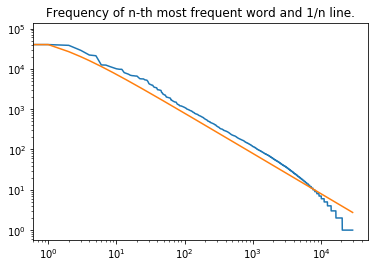

In [76]:
M = COUNTS['the']
yscale('log'); xscale('log'); title('Frequency of n-th most frequent word and 1/n line.')
plot([c for (w, c) in COUNTS.most_common()])
plot([M/i for i in range(1, len(COUNTS)+1)]);

In [77]:
P1w('neverbeforeseen')

1.7003201005861308e-12

In [78]:
singletons = (w for w in COUNTS if COUNTS[w] == 1)

lengths = map(len, singletons)

Counter(lengths).most_common()

[(7, 1357),
 (8, 1356),
 (9, 1175),
 (6, 1113),
 (10, 938),
 (5, 747),
 (11, 627),
 (12, 398),
 (4, 368),
 (13, 215),
 (3, 159),
 (14, 112),
 (2, 51),
 (15, 37),
 (16, 10),
 (17, 7)]

In [79]:
1357 / sum(list(COUNTS.values()))

0.0012277376423275445

In [82]:
def pdist_good_turing_hack(counter, onecounter, base=1/26., prior=1e-8):
    """The probability of word, given evidence from the counter.
    For unknown words, look at the one-counts from onecounter, based on length.
    This gets ideas from Good-Turing, but doesn't implement all of it.
    prior is an additional factor to make unknowns less likely.
    base is how much we attenuate probability for each letter beyond longest."""
    N = sum(list(counter.values()))
    N2 = sum(list(onecounter.values()))
    lengths = map(len, [w for w in onecounter if onecounter[w] == 1])
    ones = Counter(lengths)
    longest = max(ones)
    return (lambda word: 
            counter[word] / N if (word in counter) 
            else prior * (ones[len(word)] / N2 or 
                          ones[longest] / N2 * base ** (len(word)-longest)))

# Redefine P1w
P1w = pdist_good_turing_hack(COUNTS1, COUNTS)

In [83]:
segment('thisisatestofsegmentationofalongsequenceofwords')

['this',
 'is',
 'a',
 'test',
 'of',
 'segmentation',
 'of',
 'along',
 'sequence',
 'of',
 'words']

In [85]:
print (P1w('francisco'))
print (P1w('individuals'))

7.73314623661e-05
7.72494966889e-05


In [86]:
print ([bigram for bigram in COUNTS2 if bigram.endswith('francisco')])

['san francisco', 'San francisco']


In [87]:
print ([bigram for bigram in COUNTS2 if bigram.endswith('individuals')])

['that individuals', 'both individuals', 'or individuals', 'which individuals', 'as individuals', 'such individuals', 'the individuals', 'by individuals', 'following individuals', 'these individuals', 'some individuals', 'in individuals', 'private individuals', 'those individuals', 'of individuals', 'minded individuals', 'and individuals', 'all individuals', 'two individuals', 'for individuals', 'among individuals', 'income individuals', 'different individuals', 'affected individuals', 'many individuals', 'from individuals', 'with individuals', 'about individuals', 'few individuals', 'help individuals', 'For individuals', 'between individuals', 'qualified individuals', '<S> individuals', 'other individuals', 'interested individuals', 'are individuals', 'These individuals', 'healthy individuals', 'where individuals', 'on individuals', 'certain individuals', 'infected individuals', 'to individuals', 'more individuals']


In [171]:
def test_segmenter(segmenter, tests):
    "Try segmenter on tests; report failures; return fraction correct."
    return sum([test_one_segment(segmenter, test) 
               for test in tests]), len(tests)

def test_one_segment(segmenter, test):
    words = tokens(test)
    result = segmenter(cat(words))
    correct = (result == words)
    if not correct:
        print ('expected', words)
        print ('got     ', result)
    return correct

proverbs = ("""A little knowledge is a dangerous thing
  A man who is his own lawyer has a fool for his client
  All work and no play makes Jack a dull boy
  Better to remain silent and be thought a fool that to speak and remove all doubt;
  Do unto others as you would have them do to you
  Early to bed and early to rise, makes a man healthy, wealthy and wise
  Fools rush in where angels fear to tread
  Genius is one percent inspiration, ninety-nine percent perspiration
  If you lie down with dogs, you will get up with fleas
  Lightning never strikes twice in the same place
  Power corrupts; absolute power corrupts absolutely
  Here today, gone tomorrow
  See no evil, hear no evil, speak no evil
  Sticks and stones may break my bones, but words will never hurt me
  Take care of the pence and the pounds will take care of themselves
  Take care of the sense and the sounds will take care of themselves
  The bigger they are, the harder they fall
  The grass is always greener on the other side of the fence
  The more things change, the more they stay the same
  Those who do not learn from history are doomed to repeat it"""
  .splitlines())

In [172]:
test_segmenter(segment, proverbs)

expected ['a', 'man', 'who', 'is', 'his', 'own', 'lawyer', 'has', 'a', 'fool', 'for', 'his', 'client']
got      ['amanwhoishisownla', 'wyerhasafoolforhis', 'client']
expected ['all', 'work', 'and', 'no', 'play', 'makes', 'jack', 'a', 'dull', 'boy']
got      ['allworkandnoplay', 'makesjackadullboy']
expected ['better', 'to', 'remain', 'silent', 'and', 'be', 'thought', 'a', 'fool', 'that', 'to', 'speak', 'and', 'remove', 'all', 'doubt']
got      ['better', 'to', 'remain', 'silent', 'and', 'be', 'thought', 'afoolthattospeak', 'and', 'remove', 'all', 'doubt']
expected ['do', 'unto', 'others', 'as', 'you', 'would', 'have', 'them', 'do', 'to', 'you']
got      ['dountoothersasyou', 'would', 'havethemdotoyou']
expected ['early', 'to', 'bed', 'and', 'early', 'to', 'rise', 'makes', 'a', 'man', 'healthy', 'wealthy', 'and', 'wise']
got      ['earlytobedandear', 'lytorisemakesaman', 'health', 'ywealthyandwise']
expected ['fools', 'rush', 'in', 'where', 'angels', 'fear', 'to', 'tread']
got      ['fo

(7, 20)

In [173]:
test_segmenter(segment2, proverbs)

expected ['all', 'work', 'and', 'no', 'play', 'makes', 'jack', 'a', 'dull', 'boy']
got      ['all', 'work', 'and', 'no', 'play', 'makesjackadullboy']
expected ['fools', 'rush', 'in', 'where', 'angels', 'fear', 'to', 'tread']
got      ['f', 'oolsrushinwhere', 'angelsfeartotread']
expected ['genius', 'is', 'one', 'percent', 'inspiration', 'ninety', 'nine', 'percent', 'perspiration']
got      ['g', 'eniusisonepercent', 'inspiration', 'ninety', 'nine', 'percent', 'perspiration']
expected ['see', 'no', 'evil', 'hear', 'no', 'evil', 'speak', 'no', 'evil']
got      ['see', 'no', 'evil', 'hear', 'noevilspeaknoevil']
expected ['sticks', 'and', 'stones', 'may', 'break', 'my', 'bones', 'but', 'words', 'will', 'never', 'hurt', 'me']
got      ['stick', 'sandstones', 'may', 'break', 'my', 'bones', 'but', 'words', 'will', 'never', 'hurt', 'me']
expected ['take', 'care', 'of', 'the', 'pence', 'and', 'the', 'pounds', 'will', 'take', 'care', 'of', 'themselves']
got      ['take', 'care', 'of', 'the', 'pe

(14, 20)

In [145]:
def rot(msg, n=13): 
    "Encode a message with a rotation (Caesar) cipher." 
    return encode1(msg, alphabet[n:]+alphabet[:n])

def encode(msg, key): 
    "Encode a message with a substitution cipher." 
    table = str.maketrans(upperlower(alphabet), upperlower(key))
    return msg.translate(table) 

def upperlower(text): return text.upper() + text.lower()  


In [146]:
alphabet = 'abcdefghijklmnopqrstuvwxyz'

In [147]:
rot('This is a secret message.', 1)

'Uijt jt b tfdsfu nfttbhf.'

In [148]:
rot('This is a secret message.')

'Guvf vf n frperg zrffntr.'

In [149]:
rot(rot('This is a secret message.'))

'This is a secret message.'

In [150]:
def decode_rot(secret):
    "Decode a secret message that has been encoded with a rotation cipher."
    candidates = [rot(secret, i) for i in range(len(alphabet))]
    return max(candidates, key=lambda msg: Pwords(tokens(msg)))

In [151]:
msg = 'Who knows the answer?'
secret = rot(msg, 17)

print(secret)
print(decode_rot(secret))

Nyf befnj kyv rejnvi?
Who knows the answer?


In [164]:
cat = ''.join 

In [165]:
from subprocess import call
def encode(msg, key): 
    "Encode a message with a substitution cipher; remove non-letters." 
    msg = cat(tokens(msg))  ## Change here
    table = str.maketrans(upperlower(alphabet), upperlower(key))
    return msg.translate(table) 


In [166]:
def decode_rot(secret):
    """Decode a secret message that has been encoded with a rotation cipher,
    and which has had all the non-letters squeezed out."""
    candidates = [segment(rot(secret, i)) for i in range(len(alphabet))]
    return max(candidates, key=lambda msg: Pwords(msg))


In [167]:
def rot(msg, n=13): 
    "Encode a message with a rotation (Caesar) cipher." 
    return encode(msg, alphabet[n:]+alphabet[:n])

In [179]:
msg = 'Who knows the answer this time? Anyone? Bueller?'

secret = rot(msg, 1)

print(secret)
print(decode_rot(secret))

xiplopxtuifbotxfsuijtujnfbozpofcvfmmfs
['who', 'knows', 'the', 'answer', 'this', 'time', 'anyone', 'bueller']


In [174]:
candidates = [segment(rot(secret, i)) for i in range(len(alphabet))]

for c in candidates:
    print (c, Pwords(c))


['pahdghplmaxtglpxkm', 'ablmbfxtgrhgxunxeexk'] 8.77716243614e-33
['qbiehiqmnbyuhmqyln', 'bcmncgyuhsihyvoyffyl'] 8.77716243614e-33
['rcjfijrnoczvinrzmo', 'cdnodhzvitjizwpzggzm'] 8.77716243614e-33
['sdkgjksopdawjosan', 'pdeopeiawjukjaxqahh', 'an'] 1.53172157279e-32
['tel', 'hkltpqebxkptboqef', 'pqfjbxkvlkbyrbiibo'] 1.59553585169e-32
['ufmilmuqrfcylqucpr', 'fgqrgkcylwmlczscjjcp'] 8.77716243614e-33
['vgnjmnvrsgdzmrvdqs', 'ghrshldzmxnmdatdkkdq'] 8.77716243614e-33
['who', 'knows', 'the', 'answer', 'this', 'time', 'anyone', 'bueller'] 7.18422540159e-29
['xiplopxtuifbotxfsu', 'ijtujnfbozpofcvfmmfs'] 8.77716243614e-33
['yjqmpqyuvjgcpuygtv', 'jkuvkogcpaqpgdwgnngt'] 8.77716243614e-33
['zkrnqrzvwkhdqvzhuw', 'klvwlphdqbrqhexhoohu'] 8.77716243614e-33
['also', 'rsawxlierwaivxlmw', 'xmqiercsrifyippiv'] 4.20672157522e-30
['bmtpstbxymjfsxbjwy', 'mnxynrjfsdtsjgzjqqjw'] 8.77716243614e-33
['cnuqtucyznkgtyckxz', 'no', 'yzoskgteutkhakrrkx'] 9.45417015207e-33
['do', 'vruvdzaolhuzdlyao', 'pzaptlhufvuliblssly']